In [ ]:
%pip install openai
%pip install -U sentence-transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import rcParams
from plotly.subplots import make_subplots
from sklearn.feature_extraction.text import CountVectorizer
import openai
from google.colab import userdata
from collections import Counter
from sentence_transformers import SentenceTransformer, util
from functools import cache
import time
from itertools import combinations
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
!pip install --upgrade gdown
!gdown https://drive.google.com/uc?id=1JvyS_pf_JsHK1Jlgu1i3MeQx8r55gdW_

Downloading...
From: https://drive.google.com/uc?id=1JvyS_pf_JsHK1Jlgu1i3MeQx8r55gdW_
To: /content/Dataset_10k.csv
100% 6.40M/6.40M [00:00<00:00, 40.3MB/s]


In [ ]:
data_path = 'Dataset_10k.csv'
df = pd.read_csv(data_path)

## Exploratory Data Analysis

In [ ]:
df.columns

Index(['title', 'link', 'date', 'source', 'country', 'language',
       'translated_title', 'number_of_characters_title',
       'number_of_words_title', 'day_of_week', 'month', 'year', 'quarter',
       'is_weekend', 'is_holiday', 'source_type', 'final_redirected_URL',
       'domain_of_URL', 'subdomain_of_URL', 'URL_depth', 'top_level_domain',
       'url_length', 'author'],
      dtype='object')

In [ ]:
df[['month', 'year']].value_counts()

month  year
11     2023    2991
10     2023    2917
8      2023     979
9      2023     935
6      2023     878
7      2023     750
5      2023     550
dtype: int64

In [ ]:
df[['language']].value_counts().head(15)

language
en          8390
ko           375
ja           195
es           188
fr           119
id            92
de            90
vi            80
pt            67
it            58
nl            38
pl            31
zh-cn         28
th            23
ru            20
dtype: int64

In [ ]:
df['source'].value_counts().head(15)

Yahoo Finance        208
Forbes               194
MarkTechPost         152
The Motley Fool      130
Reuters              112
AI타임스                106
The Guardian          86
PR Newswire           82
Medium                74
TechCrunch            73
The Verge             70
Financial Times       67
Business Insider      62
ZDNet                 56
SiliconANGLE News     55
Name: source, dtype: int64

In [ ]:
len(df['source'].value_counts())

3247

## Data Cleaning

In [ ]:
df['translated_title_cleaned'] = (df['translated_title']
                                  .str.rsplit(' -', 1).str[0]
                                  .str.replace(r'[^\w\s]', '', regex=True)
                                  .str.lower())

<ipython-input-26-74f6024f86cc>:2: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  .str.rsplit(' -', 1).str[0]


In [ ]:
df['translated_title_cleaned'][30]

'revolutionising warehousing and logistics in the era of artificial intelligence'

In [ ]:
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(lemmatized_tokens)

In [ ]:
df['filtered_title'] = df['translated_title_cleaned'].apply(preprocess_text)
df['filtered_title'][0]

'artificial intelligence replace small talk'

## Data Sentiment

In [ ]:
def get_sentiment(text, pos=True):
  analyzer = SentimentIntensityAnalyzer()
  scores = analyzer.polarity_scores(text)
  if pos:
    return scores['pos']
  else:
    return scores['neg']


In [ ]:
df['pos'] = df['filtered_title'].apply(lambda x: get_sentiment(x, True))
df['neg'] = df['filtered_title'].apply(lambda x: get_sentiment(x, False))

In [ ]:
df['pos'].describe()

count    10000.000000
mean         0.170356
std          0.199661
min          0.000000
25%          0.000000
50%          0.000000
75%          0.326250
max          0.848000
Name: pos, dtype: float64

In [ ]:
df['neg'].describe()

count    10000.000000
mean         0.053339
std          0.126154
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.837000
Name: neg, dtype: float64

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['date']

0      2023-11-12
1      2023-11-12
2      2023-11-12
3      2023-11-12
4      2023-11-12
          ...    
9995   2023-05-06
9996   2023-05-05
9997   2023-05-05
9998   2023-05-05
9999   2023-05-05
Name: date, Length: 10000, dtype: datetime64[ns]

In [ ]:
# Use analytical NLP to show posiitve and negative sentiment over time
avg_pos = df.groupby('month')['pos'].mean().reset_index()
avg_neg = df.groupby('month')['neg'].mean().reset_index()
fig = make_subplots(rows=1, cols=2)
fig.add_scatter(x=avg_pos['month'], y=avg_pos['pos'], mode='lines', name='Positive Sentiment', row=1, col=1)
fig.add_scatter(x=avg_neg['month'], y=avg_neg['neg'], mode='lines', name='Negative Sentiment', row=1, col=2)
fig.update_layout(title='Positive and Negative Sentiment Scores Over Time', xaxis_title='Month', yaxis_title='Score')
fig.show()

In months August-November, positive and negative sentiments followed swaying, opposite trends. In May-July, both sentiment values were high.

<ipython-input-54-f3e8dee82509>:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-54-f3e8dee82509>:14: UserWarning:


The palette list has fewer values (1) than needed (15) and will cycle, which may produce an uninterpretable plot.

<ipython-input-54-f3e8dee82509>:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-54-f3e8dee82509>:20: UserWarning:


The palette list has fewer values (1) than needed (15) and will cycle, which may produce an uninterpretable plot.

<ipython-input-54-f3e8dee82509>:25: UserWarning:

Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from current font.

<ipython-input-54-f3e8dee82509>:25: UserWarning:

Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from current fon

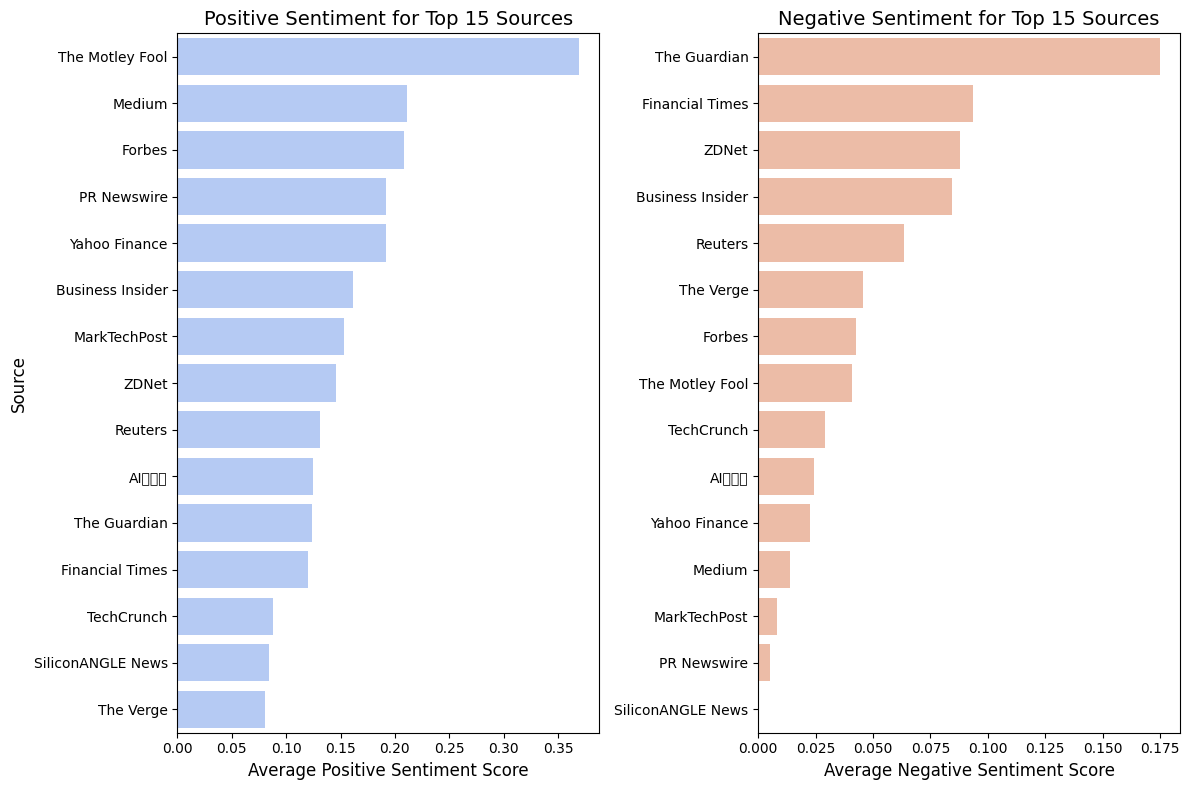

In [ ]:
# Average sentiment by top source
top_15_sources = df['source'].value_counts().head(15).index
filtered_df = df[df['source'].isin(top_15_sources)]

# Find the average pos and neg scores aggregated by source
avg_scores = filtered_df.groupby('source')[['pos', 'neg']].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 8))
palette = sns.color_palette("coolwarm", 2)
rcParams['font.family'] = 'DejaVu Sans'

plt.subplot(1, 2, 1)
sns.barplot(x='pos', y='source', data=avg_scores.sort_values(by='pos', ascending=False), palette=[palette[0]])
plt.title('Positive Sentiment for Top 15 Sources', fontsize=14)
plt.xlabel('Average Positive Sentiment Score', fontsize=12)
plt.ylabel('Source', fontsize=12)

plt.subplot(1, 2, 2)
sns.barplot(x='neg', y='source', data=avg_scores.sort_values(by='neg', ascending=False), palette=[palette[1]])
plt.title('Negative Sentiment for Top 15 Sources', fontsize=14)
plt.xlabel('Average Negative Sentiment Score', fontsize=12)
plt.ylabel('')

plt.tight_layout()
plt.show()

# Visualize text data

(-0.5, 399.5, 199.5, -0.5)

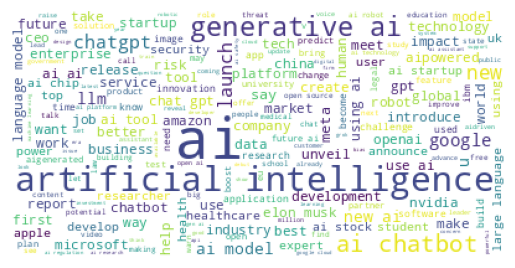

In [ ]:
# Word cloud
text = " ".join(title for title in df.filtered_title)
wc = WordCloud(background_color='white').generate(text)
plt.imshow(wc)
plt.axis('off')

In [ ]:
# Create a bag of words and see the most frequent words
def count_words(text):
  words = text.split()
  return Counter(set(words))

bag_of_words = df['filtered_title'].apply(count_words).sum()
bag_of_words = dict(sorted(bag_of_words.items(), key=lambda item: item[1], reverse=True))
bag_of_words

{'ai': 7901,
 'artificial': 1706,
 'intelligence': 1695,
 'generative': 1009,
 'new': 754,
 'chatbot': 709,
 'model': 540,
 'google': 453,
 'launch': 449,
 'chatgpt': 381,
 'use': 298,
 'tool': 288,
 'llm': 257,
 'say': 248,
 'future': 243,
 'robot': 235,
 'chatbots': 232,
 'help': 227,
 'could': 227,
 'using': 222,
 'gpt': 221,
 'data': 218,
 'aipowered': 210,
 'language': 208,
 'tech': 199,
 'chat': 197,
 'company': 194,
 'human': 192,
 'technology': 181,
 'meta': 180,
 'startup': 178,
 'u': 169,
 'open': 168,
 'microsoft': 167,
 'make': 160,
 'world': 150,
 'openai': 150,
 'musk': 149,
 'first': 149,
 'business': 149,
 'risk': 147,
 'job': 146,
 'unveils': 146,
 'stock': 137,
 'platform': 135,
 'service': 133,
 'research': 131,
 'industry': 131,
 'work': 127,
 'assistant': 122,
 'health': 121,
 'cloud': 118,
 'ceo': 117,
 'market': 116,
 'next': 112,
 'nvidia': 112,
 'elon': 111,
 'chip': 109,
 'need': 109,
 'get': 108,
 'large': 107,
 'china': 105,
 'global': 104,
 'impact': 103,
 

In [ ]:
# Filter out top 3 ("ai", "artificial", "intelligence")
x = list(bag_of_words.keys())[3:18]  # Selecting only the top 10 x values
y = list(bag_of_words.values())[3:18]  # Corresponding y values for the top 10 x values

fig = go.Bar(
    x=x,
    y=y,
    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5,
        )
    ),
    opacity=0.8
)

layout = go.Layout(
    title='Top 15 Most Frequent Words',
    xaxis=dict(
        tickmode='linear',
        tickvals=np.arange(10),
        ticktext=x,
        automargin=True
    ),
    yaxis=dict(
        title='Frequency',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    showlegend=False,
    width=800  # Adjusted width for better visualization
)

fig = go.Figure(data=[fig], layout=layout)
fig.show()

# LLMs for Insight Generation

In [ ]:
# Use GPT-4 Turbo to analyze text into categories

In [ ]:
categories = (
    'fear-mongering',
    'hype',
    'innovation and development',
    'consumer applications',
    'business applications',
    'economic implications',
    'jobs and employment',
    'language models',
    'robotics',
    'image and vision models',
    'legal and ethical issues',
    'medical issues',
    'education',
    'environment',
    'security',
    'government and regulation',
    'social impact'
)

In [ ]:
RUN = False

# get Google Colab secret key for OpenAI Key
client = openai.OpenAI(
    api_key=userdata.get('OPENAI_API_KEY')
)

def classify_headlines(headline, categories):
    prompt = (f'Classify the headline as related to categories {categories} stating True or False for each category, space separated.'
            f'Headline {headline}:\n\n')

    # Make a request to the ChatGPT 4 Turbo API
    response = client.chat.completions.create(
    messages=[
        {
            'role': 'user',
            'content': prompt
        }
      ],
        model="gpt-4-0125-preview",
        max_tokens=150,
        temperature=0
    )
    output_text = response.choices[0].message.content.strip()
    return output_text

In [ ]:
@cache  # to avoid re-calling the API on same inputs
def classify_row(headline, categories, print_output=False):
    first = classify_headlines(headline, categories)
    results = [x == 'True' for x in first.split() if x in ['True', 'False']]
    if len(results) != len(categories):
        print("Warning on headline", headline)
        results = [False for _ in range(len(categories))]
    if print_output:
        for i, cat in enumerate(categories):
            print(cat, results[i])
        print(headline)
    return results

In [ ]:
# Test chatgpt classification performance
results = classify_row(df['translated_title'][12], categories, print_output=True)

fear-mongering False
hype False
innovation and development True
consumer applications True
business applications False
economic implications False
jobs and employment False
language models False
robotics False
image and vision models False
legal and ethical issues False
medical issues False
education False
environment False
security False
government and regulation False
social impact False
YouTube announces AI tools compatible with its videos - Cointribune


In [ ]:
classify_row.cache_info()

CacheInfo(hits=2966, misses=1693, maxsize=None, currsize=1689)

In [ ]:
def apply_fn():
    applied = df['translated_title'].apply(lambda x: classify_row(x, categories, print_output=True))
    return applied

applied = None
while applied is None and RUN:
    try:
        applied = apply_fn()  # Takes advantage of caching
    except:  # Sometimes Bad Request Error
        applied = None


Streaming output truncated to the last 5000 lines.
fear-mongering False
hype False
innovation and development True
consumer applications False
business applications False
economic implications False
jobs and employment False
language models True
robotics False
image and vision models False
legal and ethical issues False
medical issues False
education False
environment False
security False
government and regulation False
social impact False
Google presents PaLM 2, new AI model to compete with GPT-4 - Olhar Digital
fear-mongering False
hype False
innovation and development False
consumer applications False
business applications False
economic implications False
jobs and employment False
language models True
robotics False
image and vision models False
legal and ethical issues False
medical issues False
education False
environment False
security False
government and regulation True
social impact False
Scale AI Partners with XVIII Airborne Corps for First LLM ... - Business Wire
fear-monge

In [ ]:
applied

0       [False, False, False, False, False, False, Fal...
1       [False, False, False, False, False, False, Fal...
2       [False, False, False, True, True, False, False...
3       [False, False, False, False, False, False, Fal...
4       [False, False, False, False, False, False, Fal...
                              ...                        
9995    [False, False, False, False, False, False, Fal...
9996    [False, False, False, False, False, False, Fal...
9997    [False, False, False, False, True, False, Fals...
9998    [False, False, True, False, True, False, False...
9999    [False, False, True, True, False, False, False...
Name: translated_title, Length: 10000, dtype: object

In [ ]:
if RUN:
    df[[categories[i] for i in range(len(categories))]] = pd.DataFrame(applied.tolist(), index=df.index)

In [ ]:
if RUN:
    df.to_csv('processed_df.csv')

    ## Save to drive
    # from google.colab import drive
    # drive.mount('/content/drive')
    !cp processed_df.csv /content/drive/MyDrive/RAISE/Data

Used Chatgpt 4 Turbo, as during tests we found it much more performant than chatgpt 3.5 turbo at classification tasks for the categories we gave it.

In [ ]:
!pip install --upgrade gdown
!gdown https://drive.google.com/uc?id=1KWKk0-zZnMgEuen42OufTA_ygxXmamEG

# Use processed_df.csv
processed_df = pd.read_csv('processed_df.csv')

Downloading...
From: https://drive.google.com/uc?id=1KWKk0-zZnMgEuen42OufTA_ygxXmamEG
To: /content/processed_df.csv
100% 8.76M/8.76M [00:00<00:00, 52.5MB/s]


# Clustering

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')
titles = list(processed_df['filtered_title'])
encoded_titles = model.encode(titles, batch_size=64, show_progress_bar=True, convert_to_tensor=True)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
clusters = util.community_detection(encoded_titles, min_community_size=30, threshold=0.60)
clusters_dict = {}
for i, cluster in enumerate(clusters):
  for sentence_id in cluster:
    if f'Cluster {i}' not in clusters_dict:
      clusters_dict[f'Cluster {i}'] = [titles[sentence_id]]
    else:
      clusters_dict[f'Cluster {i}'].append(titles[sentence_id])
clusters_dict

{'Cluster 0': ['ai chatbot work',
  'ai chatbots',
  'conversing ai chatbot',
  'best ai chatbot tool business',
  'ai chatbots coming workplace',
  'using ai chatbots wrong here direct',
  'best ai chatbots far',
  'uber developing ai chatbot',
  'next job interview could ai chatbot',
  'pi work new artificial intelligence chatbot designed',
  'insurtech artificial intelligence chatbot application',
  'technology artificial intelligence new chatbot',
  'ai new chatbot equipped intelligence',
  'ai chatbots serve lot info correct',
  'ai chatbots popular muo',
  'chatbot know ai implement business',
  'ai chatbots make robot astonishingly intelligent',
  'chatbots ai system danger',
  'feature interactive ai much chatbot',
  'ai chatbots help user find job',
  'thing must share ai chatbots muo',
  'chat chatgpt ai powered chatbot answer',
  'ai chatbots coming workplace necessarily',
  'ai chatbots coming web browser big way',
  'ai chatbot popular helpful u know important thing relate

In [ ]:
RUN2 = False

client = openai.OpenAI(
    api_key=userdata.get('OPENAI_API_KEY')
)

@cache
def describe_clusters(headlines):
    prompt = (f'Create a label for this list of article titles. \n{headlines}.\n Response Format: {"Label"}#{"Description"}')

    # Make a request to the ChatGPT 4 Turbo API
    response = client.chat.completions.create(
    messages=[
        {
            'role': 'user',
            'content': prompt
        }
      ],
        model="gpt-4-0125-preview",
        temperature=0
    )
    output_text = response.choices[0].message.content.strip()
    return output_text

In [ ]:
if RUN2:
    descriptions = []
    for i in range(len(clusters)):
        headlines = clusters_dict[f'Cluster {i}']
        print(headlines)
        desc = describe_clusters(tuple(headlines))
        print(desc)
        descriptions.append(desc)

['ai chatbot work', 'ai chatbots', 'conversing ai chatbot', 'best ai chatbot tool business', 'ai chatbots coming workplace', 'using ai chatbots wrong here direct', 'best ai chatbots far', 'uber developing ai chatbot', 'next job interview could ai chatbot', 'pi work new artificial intelligence chatbot designed', 'insurtech artificial intelligence chatbot application', 'technology artificial intelligence new chatbot', 'ai new chatbot equipped intelligence', 'ai chatbots serve lot info correct', 'ai chatbots popular muo', 'chatbot know ai implement business', 'ai chatbots make robot astonishingly intelligent', 'chatbots ai system danger', 'feature interactive ai much chatbot', 'ai chatbots help user find job', 'thing must share ai chatbots muo', 'chat chatgpt ai powered chatbot answer', 'ai chatbots coming workplace necessarily', 'ai chatbots coming web browser big way', 'ai chatbot popular helpful u know important thing related', 'artificial intelligence ai chatbots like chatgpt', 'asked

In [ ]:
for i in range(len(descriptions)):
    descriptions[i] = descriptions[i].replace('Label: ', '').replace('Description: ', '#').replace(' # ', '#').replace('##', '#').replace('\n', '')

In [ ]:
clusters_df = pd.DataFrame([s.split("#") for s in descriptions], columns=["Label", "Description"])

In [ ]:
clusters_df['Count'] = [len(clusters_dict[f'Cluster {i}']) for i in range(len(clusters_dict))]

In [ ]:
clusters_df

,Label,Description,Count
0,AI Chatbots and Their Impact on Various Sectors,This list encompasses a broad range of article...,856
1,AI and Artificial Intelligence Advancements,This label encompasses a wide range of topics ...,538
2,AI in Business,This collection of article titles focuses on t...,273
3,Generative AI in Business and Technology,This collection of article titles encompasses ...,176
4,ChatGPT and AI Industry Developments,This list encompasses a wide range of articles...,160
5,AI in Education,This collection of article titles focuses on t...,121
6,AI Regulation and Governance,This list compiles articles focused on the reg...,106
7,Generative AI Developments and Insights,This collection of article titles encompasses ...,105
8,AI in Healthcare,This list encompasses a wide range of articles...,95
9,Artificial Intelligence in Finance and Investment,This collection of article titles focuses on t...,78


In [ ]:
clusters_df.to_csv('clusters_df.csv')
!cp clusters_df.csv /content/drive/MyDrive/RAISE/Data

In [ ]:
# To download saved copy
!gdown https://drive.google.com/uc?id=1LTSa6-6kVMlIXLkba4zl_oYZyOd_yPDv
clusters_df = pd.read_csv('clusters_df.csv')

Downloading...
From: https://drive.google.com/uc?id=1LTSa6-6kVMlIXLkba4zl_oYZyOd_yPDv
To: /content/clusters_df.csv
100% 20.4k/20.4k [00:00<00:00, 54.6MB/s]


# Analyze Clusters

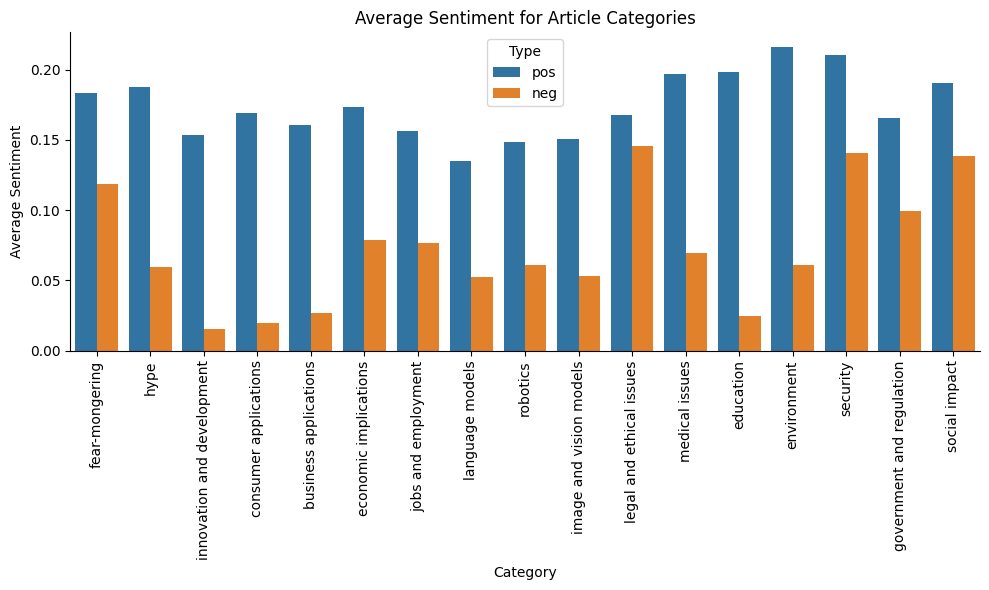

In [ ]:
# Plot average sentiment by category
plot_data = []
for category in categories:
    filtered_df = processed_df[processed_df[category]]
    avg_pos = filtered_df['pos'].mean()
    avg_neg = filtered_df['neg'].mean()
    plot_data.append({'Category': category, 'Type': 'pos', 'Value': avg_pos})
    plot_data.append({'Category': category, 'Type': 'neg', 'Value': avg_neg})

plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Value', hue='Type', data=plot_df)
plt.title('Average Sentiment for Article Categories')
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Average Sentiment')
sns.despine()
plt.tight_layout()
plt.show()

# Co-Occurence Matrix

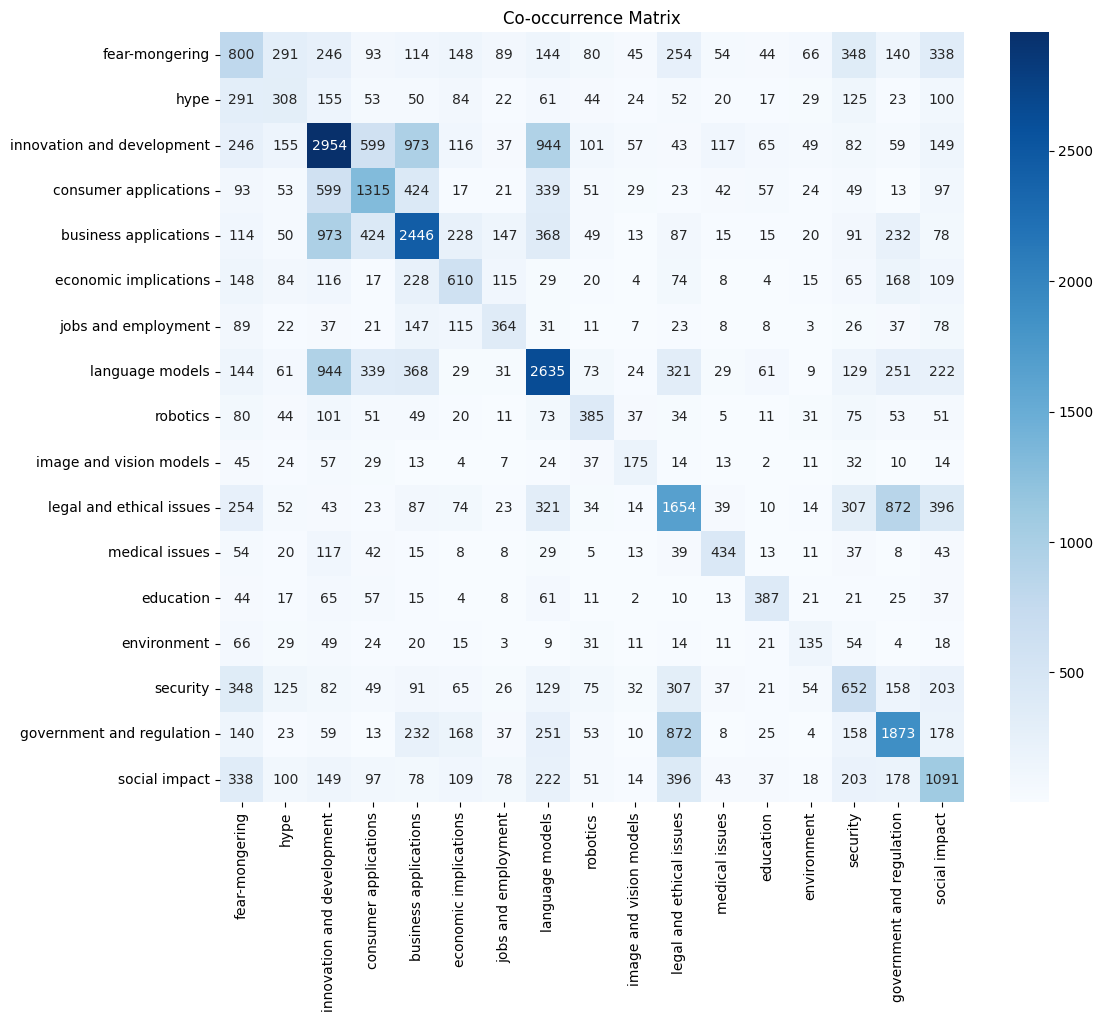

In [ ]:
matrix_df = processed_df[list(categories)].astype(int)

# Create a co-occurrence matrix
co_occurrence_matrix = matrix_df.T.dot(matrix_df).values

# Visualize the co-occurrence matrix
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=matrix_df.columns, yticklabels=matrix_df.columns)
plt.title("Co-occurrence Matrix")
plt.show()
